In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

## regression model
import statsmodels.api as sm

## variable transformation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.stats import zscore

## diagnostic test
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

## permutation importance
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
sys.path.insert(0,str(Path(os.path.abspath('.')).parent.parent))


## Read data

In [2]:
ticket_path = Path.home()/"OneDrive-3E/Research/Solar/tickets/2024/IN3043_accuracy_factors_analysis"
complexity = pd.read_csv(os.path.join(ticket_path, 'complexity.csv'), index_col=0)
complexity

,country,latitude,longitude,altitude,provider,terrain_classification,tri_1km,tri_5km,tri_10km,tpi_1km,tpi_5km,tpi_10km,distance_to_coastline_km,climate_zone,clearness (%),climate_classification
station_name,,,,,,,,,,,,,,,,
camborne,United Kingdom,50.22,-5.32,88.0,bsrn,_flat plains,1.6250,2.875,2.875,0.2500,0.125,0.0,3.211302,Cfb,68.509617,C
carpentras,France,44.08,5.06,100.0,bsrn,_flat plains,1.5000,2.000,1.375,0.0000,0.000,0.0,57.987479,Cfb,84.703463,C
budapest_lorinc,Hungary,47.43,19.18,139.0,bsrn,_flat plains,2.1250,1.375,1.500,0.1875,0.000,0.0,482.028360,Cfb,73.573263,C
magurele_mars,Romania,44.34,26.01,110.0,bsrn,_flat plains,0.8125,0.750,0.875,0.0000,0.000,0.0,198.059538,Cfa,76.351207,C
cabauw,Netherlands,51.97,4.93,0.0,bsrn,_flat plains,0.7500,0.500,0.500,0.0625,0.000,0.0,49.955084,Cfb,70.044037,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dublin_arpt,Ireland,53.43,-6.23,82.0,wrdc,_flat plains,1.5000,1.250,1.125,-0.1250,0.125,0.0,4.175609,Cfb,64.296802,C
grossenzersdorf,Austria,48.20,16.57,157.0,wrdc,_flat plains,1.0000,1.125,1.125,0.0625,0.000,0.0,357.351298,Cfb,71.090746,C
gonzaga,Italy,44.96,10.77,16.0,lombardy,_flat plains,0.8750,1.125,1.000,0.0000,0.000,0.0,117.377329,Cfa,78.808519,C


In [3]:
results_path = os.path.join(ticket_path, "IN3136_EURAC_shared_folder/validation")
validation_metrics = pd.read_csv(os.path.join(results_path, "validation_metrics.csv"), index_col = 0)
validation_metrics

,nmbe,nrmse_yearly,nrmse_monthly,nrmse_daily,nrmse_hourly,valid_data_pairs_daily,valid_data_pairs_hourly
camborne,-1.713271,2.390578,2.960226,20.515307,19.891331,12474,11704.0
carpentras,-0.667623,0.908728,2.305455,11.637070,11.227009,19023,17686.0
budapest_lorinc,-0.438789,0.516789,2.504264,15.510051,15.026375,12229,11460.0
magurele_mars,-0.241528,0.241528,2.793683,13.151986,12.704396,3306,3081.0
cabauw,-0.199198,0.609549,2.155886,16.649853,16.077524,33360,31050.0
...,...,...,...,...,...,...,...
dublin_arpt,3.362028,3.494330,5.239870,9.972663,NaN,2187,NaN
grossenzersdorf,5.926388,6.072439,6.855718,9.840883,NaN,2192,NaN
gonzaga,-6.679113,6.724571,7.997686,38.823848,16.058042,33448,28018.0
landriano,-0.069454,1.363417,3.209997,38.937531,12.993406,33280,27945.0


In [4]:
validation = validation_metrics.drop(['valid_data_pairs_daily', 'valid_data_pairs_hourly'], axis=1)

validation = complexity.merge(validation, how='inner', left_index=True, right_index=True)
validation = validation.drop(['country', 'provider'], axis=1)
validation

,latitude,longitude,altitude,terrain_classification,tri_1km,tri_5km,tri_10km,tpi_1km,tpi_5km,tpi_10km,distance_to_coastline_km,climate_zone,clearness (%),climate_classification,nmbe,nrmse_yearly,nrmse_monthly,nrmse_daily,nrmse_hourly
camborne,50.22,-5.32,88.0,_flat plains,1.6250,2.875,2.875,0.2500,0.125,0.0,3.211302,Cfb,68.509617,C,-1.713271,2.390578,2.960226,20.515307,19.891331
carpentras,44.08,5.06,100.0,_flat plains,1.5000,2.000,1.375,0.0000,0.000,0.0,57.987479,Cfb,84.703463,C,-0.667623,0.908728,2.305455,11.637070,11.227009
budapest_lorinc,47.43,19.18,139.0,_flat plains,2.1250,1.375,1.500,0.1875,0.000,0.0,482.028360,Cfb,73.573263,C,-0.438789,0.516789,2.504264,15.510051,15.026375
magurele_mars,44.34,26.01,110.0,_flat plains,0.8125,0.750,0.875,0.0000,0.000,0.0,198.059538,Cfa,76.351207,C,-0.241528,0.241528,2.793683,13.151986,12.704396
cabauw,51.97,4.93,0.0,_flat plains,0.7500,0.500,0.500,0.0625,0.000,0.0,49.955084,Cfb,70.044037,C,-0.199198,0.609549,2.155886,16.649853,16.077524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dublin_arpt,53.43,-6.23,82.0,_flat plains,1.5000,1.250,1.125,-0.1250,0.125,0.0,4.175609,Cfb,64.296802,C,3.362028,3.494330,5.239870,9.972663,NaN
grossenzersdorf,48.20,16.57,157.0,_flat plains,1.0000,1.125,1.125,0.0625,0.000,0.0,357.351298,Cfb,71.090746,C,5.926388,6.072439,6.855718,9.840883,NaN
gonzaga,44.96,10.77,16.0,_flat plains,0.8750,1.125,1.000,0.0000,0.000,0.0,117.377329,Cfa,78.808519,C,-6.679113,6.724571,7.997686,38.823848,16.058042
landriano,45.32,9.27,88.0,_flat plains,0.8750,0.875,0.875,0.0000,0.000,0.0,105.966234,Cfa,78.543263,C,-0.069454,1.363417,3.209997,38.937531,12.993406


## Fit model

### variable transformer

specify dependent and independent variables

In [5]:
X = complexity[['tri_1km', 'tri_5km', 'tri_10km', 'tpi_1km', 'tpi_5km', 'tpi_10km', 'distance_to_coastline_km', 'clearness (%)', 'terrain_classification', 'climate_zone']]
y_daily_nrmse = validation_metrics['nrmse_daily']

specify categorical and numerical independent variables

In [6]:
categorical_cols = ['terrain_classification', 'climate_zone']
numerical_cols = ['tri_1km', 'tri_5km', 'tri_10km', 'tpi_1km', 'tpi_5km', 'tpi_10km', 'distance_to_coastline_km', 'clearness (%)']


<span style='background-color: lightyellow'>OndeHotEncoder:</span> Turn categorical variables into binary features.  
If a feature is represented by that column, it receives a 1. Otherwise, it receives a 0.

<span style='background-color: lightyellow'>MinMaxScaler</span>: Scale and translate each feature individually to range (0,1)

In [7]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



In [9]:
X_encoded = preprocessor.fit_transform(X)

categorical_encoded_cols = preprocessor.named_transformers_['cat']['onehot'] \
                                .get_feature_names_out(input_features=categorical_cols)

all_encoded_cols = list(numerical_cols) + list(categorical_encoded_cols)

X_encoded = pd.DataFrame(X_encoded, columns=all_encoded_cols, index=X.index)

X_encoded = sm.add_constant(X_encoded)


In [10]:
X_encoded

,const,tri_1km,tri_5km,tri_10km,tpi_1km,tpi_5km,tpi_10km,distance_to_coastline_km,clearness (%),terrain_classification__flat plains,...,terrain_classification__tablelands,terrain_classification_nan,climate_zone_BSk,climate_zone_Cfa,climate_zone_Cfb,climate_zone_Cfc,climate_zone_Csa,climate_zone_Csb,climate_zone_Dfb,climate_zone_nan
station_name,,,,,,,,,,,,,,,,,,,,,
camborne,1.0,0.126214,0.343284,0.46,0.642857,0.6,0.5,0.006267,0.396666,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
carpentras,1.0,0.116505,0.238806,0.22,0.500000,0.4,0.5,0.118059,0.887691,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
budapest_lorinc,1.0,0.165049,0.164179,0.24,0.607143,0.4,0.5,0.983480,0.550204,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
magurele_mars,1.0,0.063107,0.089552,0.14,0.500000,0.4,0.5,0.403931,0.634436,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cabauw,1.0,0.058252,0.059701,0.08,0.535714,0.4,0.5,0.101666,0.443192,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dublin_arpt,1.0,0.116505,0.149254,0.18,0.428571,0.6,0.5,0.008235,0.268926,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
grossenzersdorf,1.0,0.077670,0.134328,0.18,0.535714,0.4,0.5,0.729028,0.474930,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
gonzaga,1.0,0.067961,0.134328,0.16,0.500000,0.4,0.5,0.239268,0.708946,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### model fitting

In [11]:
model_daily_nrmse = sm.OLS(y_daily_nrmse, X_encoded)
result_daily_nrmse = model_daily_nrmse.fit()

summary_daily_nrmse = result_daily_nrmse.summary()
print(summary_daily_nrmse)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.061
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.413
Time:                        14:34:17   Log-Likelihood:                -346.70
No. Observations:                  80   AIC:                             739.4
Df Residuals:                      57   BIC:                             794.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Diagnostic test

In [12]:
residuals_daily_nrmse = result_daily_nrmse.resid
predicted_daily_nrmse = result_daily_nrmse.predict(X_encoded)


### Linearity

There exists a linear relationship between the independent variable and the dependent variable.

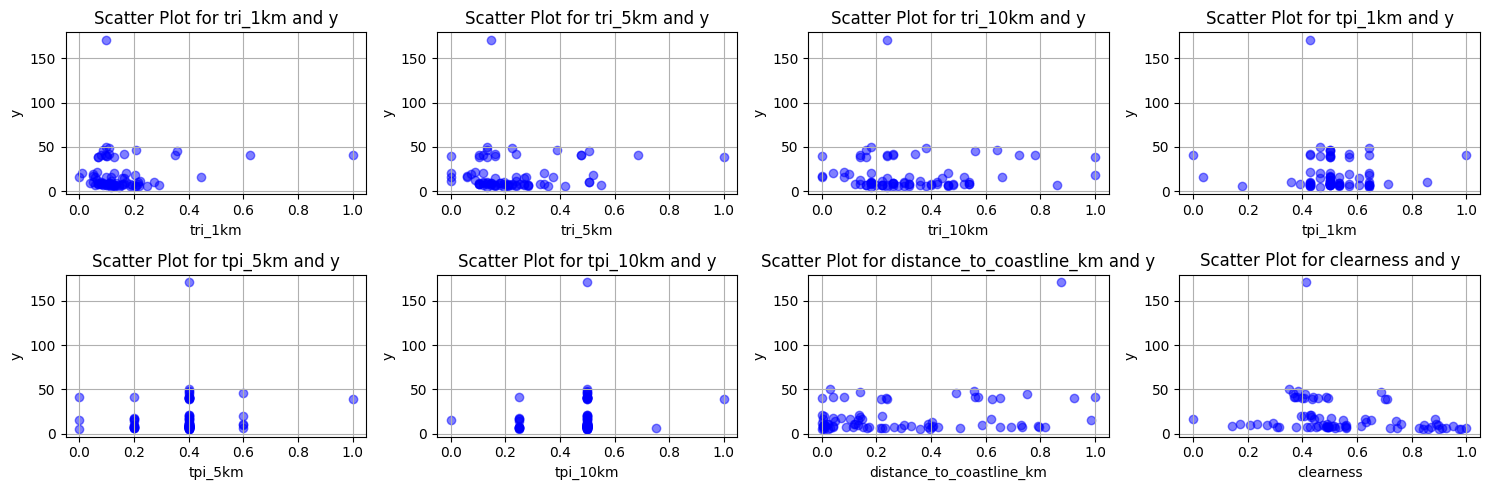

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

axes[0, 0].scatter(X_encoded.iloc[:, 1], y_daily_nrmse, color='blue', alpha=0.5)
axes[0, 0].set_title('Scatter Plot for tri_1km and y')
axes[0, 0].set_xlabel('tri_1km')
axes[0, 0].set_ylabel('y')
axes[0, 0].grid(True)

axes[0, 1].scatter(X_encoded.iloc[:, 2], y_daily_nrmse, color='blue', alpha=0.5)
axes[0, 1].set_title('Scatter Plot for tri_5km and y')
axes[0, 1].set_xlabel('tri_5km')
axes[0, 1].set_ylabel('y')
axes[0, 1].grid(True)

axes[0, 2].scatter(X_encoded.iloc[:, 3], y_daily_nrmse, color='blue', alpha=0.5)
axes[0, 2].set_title('Scatter Plot for tri_10km and y')
axes[0, 2].set_xlabel('tri_10km')
axes[0, 2].set_ylabel('y')
axes[0, 2].grid(True)

axes[0, 3].scatter(X_encoded.iloc[:, 4], y_daily_nrmse, color='blue', alpha=0.5)
axes[0, 3].set_title('Scatter Plot for tpi_1km and y')
axes[0, 3].set_xlabel('tpi_1km')
axes[0, 3].set_ylabel('y')
axes[0, 3].grid(True)

axes[1, 0].scatter(X_encoded.iloc[:, 5], y_daily_nrmse, color='blue', alpha=0.5)
axes[1, 0].set_title('Scatter Plot for tpi_5km and y')
axes[1, 0].set_xlabel('tpi_5km')
axes[1, 0].set_ylabel('y')
axes[1, 0].grid(True)

axes[1, 1].scatter(X_encoded.iloc[:, 6], y_daily_nrmse, color='blue', alpha=0.5)
axes[1, 1].set_title('Scatter Plot for tpi_10km and y')
axes[1, 1].set_xlabel('tpi_10km')
axes[1, 1].set_ylabel('y')
axes[1, 1].grid(True)

axes[1, 2].scatter(X_encoded.iloc[:, 7], y_daily_nrmse, color='blue', alpha=0.5)
axes[1, 2].set_title('Scatter Plot for distance_to_coastline_km and y')
axes[1, 2].set_xlabel('distance_to_coastline_km')
axes[1, 2].set_ylabel('y')
axes[1, 2].grid(True)

axes[1, 3].scatter(X_encoded.iloc[:, 8], y_daily_nrmse, color='blue', alpha=0.5)
axes[1, 3].set_title('Scatter Plot for clearness and y')
axes[1, 3].set_xlabel('clearness')
axes[1, 3].set_ylabel('y')
axes[1, 3].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Normality

The residuals of the model are normally distributed.

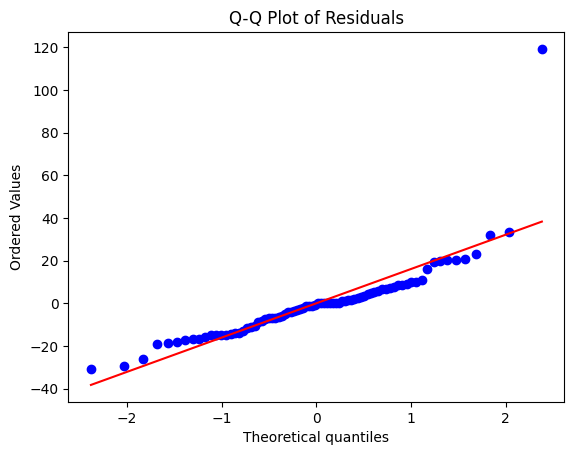

In [14]:
stats.probplot(residuals_daily_nrmse, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The scatter points are close to the red line.  
Residuals are normally distributed.

### Homoscedasticity

The residuals have constant variance at every level of x.

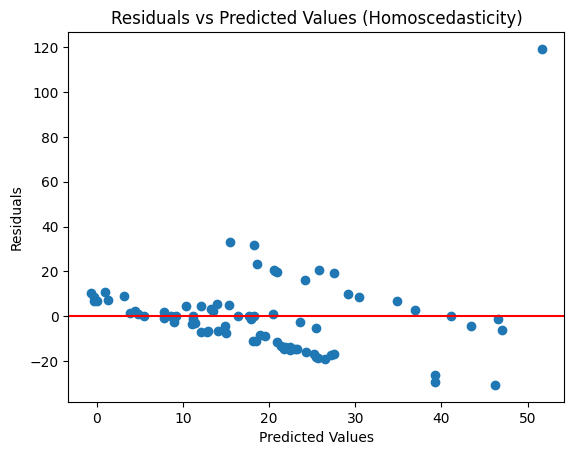

In [15]:
plt.scatter(predicted_daily_nrmse, residuals_daily_nrmse)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Homoscedasticity)')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

The scatter points spread evenly around the red line.  
Homoscedasticity is satisfied.

### Multicollinearity

There is no correlation between independent variables.

In [16]:
vif = pd.DataFrame()
vif["Feature"] = numerical_cols
vif["VIF"] = [variance_inflation_factor(X_encoded[numerical_cols].values, i) for i in range(X_encoded[numerical_cols].shape[1])]
print(vif)

                    Feature        VIF
0                   tri_1km   4.327879
1                   tri_5km  13.421635
2                  tri_10km  13.225850
3                   tpi_1km  16.885342
4                   tpi_5km  26.602603
5                  tpi_10km  33.031065
6  distance_to_coastline_km   2.252315
7             clearness (%)   6.042610


Variables with large VIF values have correlation with other predictor variables in the model.  
<ul>
 <li>Remove one or more of the highly correlated variables.</li>
 <li>Linearly combine the predictor variables.</li>
 <li>PCA.</li>
 </ul>


## Select variables

### Permutation importance

<span style='background-color: lightyellow'>Permutation feature importance</span>
<ul>
    <li>definition: A model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance.</li> 
    <li>determination: The higher the importance score, the more important the variable.</li>
    <li>principle: Randomly shuffle the values of a specific feature, breaking any original relationship between that feature and the target variable. The difference in performance between the model with the original feature and the model with the permuted feature indicates the importance of that particular feature.</li>
    </ul>

In [17]:
model = LinearRegression().fit(X_encoded, y_daily_nrmse)

perm_importance = permutation_importance(model, X_encoded, y_daily_nrmse, n_repeats=10, random_state=27)

feature_names = X_encoded.columns

for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]:<8} "
          f"{perm_importance.importances_mean[i]:.3f}"
          f" +/- {perm_importance.importances_std[i]:.3f}")


distance_to_coastline_km 0.583 +/- 0.115
clearness (%) 0.373 +/- 0.098
tri_5km  0.133 +/- 0.048
terrain_classification__high hills 0.128 +/- 0.042
terrain_classification_nan 0.118 +/- 0.056
terrain_classification__flat plains 0.108 +/- 0.068
tpi_1km  0.102 +/- 0.023
climate_zone_Cfc 0.065 +/- 0.019
tri_10km 0.064 +/- 0.025
climate_zone_Cfa 0.064 +/- 0.033
tri_1km  0.052 +/- 0.028
climate_zone_Csb 0.048 +/- 0.032
climate_zone_Cfb 0.044 +/- 0.029
climate_zone_Csa 0.039 +/- 0.026
terrain_classification__irregular plains 0.035 +/- 0.017
climate_zone_BSk 0.021 +/- 0.013
climate_zone_Dfb 0.015 +/- 0.015
terrain_classification__tablelands 0.013 +/- 0.007
tpi_5km  0.013 +/- 0.013
terrain_classification__low mountains 0.003 +/- 0.003
tpi_10km 0.003 +/- 0.002
climate_zone_nan 0.000 +/- 0.001
const    0.000 +/- 0.000
terrain_classification__rough low hills -0.000 +/- 0.000
terrain_classification__smooth low hills -0.001 +/- 0.001


#### permutation significant factors

Keep the several most important variables, including as many aspects of factors as possible.

In [18]:
X_encoded_per_significant = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'tri_5km', 'terrain_classification__flat plains', 'terrain_classification__high hills', 'tpi_1km', 'climate_zone_Cfc', 'tri_1km', 'climate_zone_Cfa']]

In [19]:
model_daily_nrmse_per_sig = sm.OLS(y_daily_nrmse, X_encoded_per_significant)
result_daily_nrmse_per_sig = model_daily_nrmse_per_sig.fit()

summary_daily_nrmse_per_sig = result_daily_nrmse_per_sig.summary()
print(summary_daily_nrmse_per_sig)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.087
Date:                Thu, 11 Apr 2024   Prob (F-statistic):             0.0422
Time:                        14:37:00   Log-Likelihood:                -350.93
No. Observations:                  80   AIC:                             721.9
Df Residuals:                      70   BIC:                             745.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

#### backward manually

<ul>
    <li><span style='background-color: lightyellow'>R-squared</span> measures the proportion of the variance in the dependent variable that is explained by the independent variables in the model. R-squared ranges from 0 to 1, where 1 indicates that the model explains all the variance in the dependent variable.</li>
    <li><span style='background-color: lightyellow'>Adjusted R-squared</span> is a modified version of R-squared that penalizes the addition of unnecessary variables in the model. It accounts for the number of predictors. It is similar to R-squared but adjusted for model complexity, and higher values indicate a better-fitted model.</li>
    <li><span style='background-color: lightyellow'>AIC</span> estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.</li>
    <li>The formula for the <span style='background-color: lightyellow'>BIC</span> is similar to the formula for AIC, but with a different penalty for the number of parameters.</li>
    <li>A small <span style='background-color: lightyellow'>p-value</span> (typically below a significance level like 0.05) suggests that there is evidence to reject the null hypothesis, meaning that there is a statistically significant relationship between the predictor variable and the response variable.</li>
    </ul>

remove variable **climate_zone_Cfc** (*p=0.971*)


In [20]:
X_encoded_dairm_ste1 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'tri_5km', 'terrain_classification__flat plains', 'terrain_classification__high hills', 'tpi_1km', 'tri_1km', 'climate_zone_Cfa']]

model_nmbe_ste1 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste1)
result_nmbe_ste1 = model_nmbe_ste1.fit()
result_nmbe_ste1 = model_nmbe_ste1.fit()

summary_nmbe_ste1 = result_nmbe_ste1.summary()
print(summary_nmbe_ste1)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.381
Date:                Thu, 11 Apr 2024   Prob (F-statistic):             0.0247
Time:                        14:38:13   Log-Likelihood:                -350.93
No. Observations:                  80   AIC:                             719.9
Df Residuals:                      71   BIC:                             741.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

remove variable **tri_1km** (*p=0.665*)


In [21]:
X_encoded_dairm_ste2 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'tri_5km', 'terrain_classification__flat plains', 'terrain_classification__high hills', 'tpi_1km', 'climate_zone_Cfa']]

model_nmbe_ste2 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste2)
result_nmbe_ste2 = model_nmbe_ste2.fit()
result_nmbe_ste2 = model_nmbe_ste2.fit()

summary_nmbe_ste2 = result_nmbe_ste2.summary()
print(summary_nmbe_ste2)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     2.725
Date:                Thu, 11 Apr 2024   Prob (F-statistic):             0.0145
Time:                        14:38:57   Log-Likelihood:                -351.04
No. Observations:                  80   AIC:                             718.1
Df Residuals:                      72   BIC:                             737.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

remove variable **terrain_classification__high hills** (*p=0.687*)


In [22]:
X_encoded_dairm_ste3 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'tri_5km', 'terrain_classification__flat plains', 'tpi_1km', 'climate_zone_Cfa']]

model_nmbe_ste3 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste3)
result_nmbe_ste3 = model_nmbe_ste3.fit()
result_nmbe_ste3 = model_nmbe_ste3.fit()

summary_nmbe_ste3 = result_nmbe_ste3.summary()
print(summary_nmbe_ste3)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     3.188
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00779
Time:                        14:39:15   Log-Likelihood:                -351.13
No. Observations:                  80   AIC:                             716.3
Df Residuals:                      73   BIC:                             732.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

remove variable **tri_5km** (*p=0.430*)


In [23]:
X_encoded_dairm_ste4 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'terrain_classification__flat plains', 'tpi_1km', 'climate_zone_Cfa']]

model_nmbe_ste4 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste4)
result_nmbe_ste4 = model_nmbe_ste4.fit()
result_nmbe_ste4 = model_nmbe_ste4.fit()

summary_nmbe_ste4 = result_nmbe_ste4.summary()
print(summary_nmbe_ste4)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3.719
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00466
Time:                        14:39:38   Log-Likelihood:                -351.47
No. Observations:                  80   AIC:                             714.9
Df Residuals:                      74   BIC:                             729.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

remove variable **tpi_1km** (*p=0.386*)


In [24]:
X_encoded_dairm_ste5 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'terrain_classification__flat plains', 'climate_zone_Cfa']]

model_nmbe_ste5 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste5)
result_nmbe_ste5 = model_nmbe_ste5.fit()
result_nmbe_ste5 = model_nmbe_ste5.fit()

summary_nmbe_ste5 = result_nmbe_ste5.summary()
print(summary_nmbe_ste5)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.473
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00269
Time:                        14:39:45   Log-Likelihood:                -351.88
No. Observations:                  80   AIC:                             713.8
Df Residuals:                      75   BIC:                             725.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

**model_nmbe_ste5** obtains the highest *R-sqaured* and *Adj. R-sqaured*.

remove variable **terrain_classification__flat plains** (*p=0.259*)


In [25]:
X_encoded_dairm_ste6 = X_encoded[['const', 'distance_to_coastline_km', 'clearness (%)', 'climate_zone_Cfa']]

model_nmbe_ste6 = sm.OLS(y_daily_nrmse, X_encoded_dairm_ste6)
result_nmbe_ste6 = model_nmbe_ste6.fit()
result_nmbe_ste6 = model_nmbe_ste6.fit()

summary_nmbe_ste6 = result_nmbe_ste6.summary()
print(summary_nmbe_ste6)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     5.511
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00177
Time:                        14:47:01   Log-Likelihood:                -352.56
No. Observations:                  80   AIC:                             713.1
Df Residuals:                      76   BIC:                             722.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Interaction terms

In [26]:
X_y = validation[['nmbe', 'nrmse_daily']].merge(X_encoded, how='inner', left_index=True, right_index=True)


In [27]:
X_y = X_y.drop('const', axis=1)

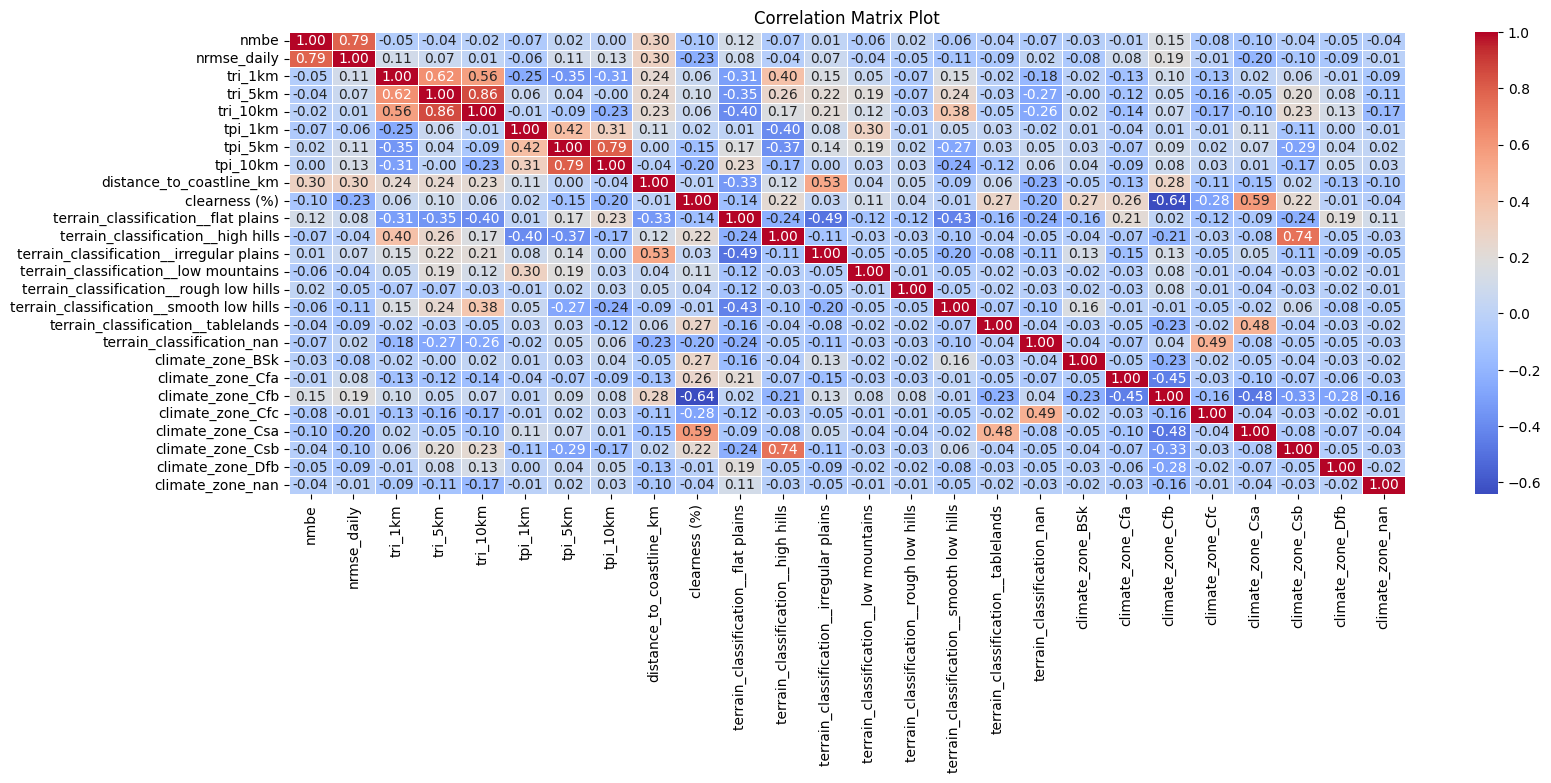

In [28]:
correlation_matrix = X_y.corr()

plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Plot')
plt.show()


#### Csb & high hills

In [30]:
interaction_column_1 = X_encoded['climate_zone_Cfb'] * X_encoded['clearness (%)']

interaction_column_2 = X_encoded['climate_zone_Csb'] * X_encoded['terrain_classification__high hills']
X_inter_daily = pd.concat([X_encoded, pd.DataFrame(interaction_column_1, columns=['climate_zone_Cfb * clearness (%)']), pd.DataFrame(interaction_column_2, columns=['climate_zone_Csb * terrain_classification__high hills'])], axis=1)

In [31]:
X_inter_daily[X_inter_daily['climate_zone_Csb * terrain_classification__high hills'] == 1]


,const,tri_1km,tri_5km,tri_10km,tpi_1km,tpi_5km,tpi_10km,distance_to_coastline_km,clearness (%),terrain_classification__flat plains,...,climate_zone_BSk,climate_zone_Cfa,climate_zone_Cfb,climate_zone_Cfc,climate_zone_Csa,climate_zone_Csb,climate_zone_Dfb,climate_zone_nan,climate_zone_Cfb * clearness (%),climate_zone_Csb * terrain_classification__high hills
station_name,,,,,,,,,,,,,,,,,,,,,
leon_arpt,1.0,0.203883,0.358209,0.38,0.178571,0.2,0.50,0.213423,0.825761,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
valladolid,1.0,0.247573,0.417910,0.46,0.428571,0.0,0.25,0.395701,0.860039,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
salamanca,1.0,0.087379,0.179104,0.26,0.535714,0.4,0.50,0.585508,0.843444,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [33]:
X_int2 = pd.concat([X_encoded, pd.DataFrame(interaction_column_2, columns=['climate_zone_Csb * terrain_classification__high hills'])], axis=1)


In [34]:
model_daily_nrmse_int2 = sm.OLS(y_daily_nrmse, X_int2)
result_daily_nrmse_int2 = model_daily_nrmse_int2.fit()

# Get the summary of the model
summary_daily_nrmse_int2 = result_daily_nrmse_int2.summary()
print(summary_daily_nrmse_int2)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9975
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.483
Time:                        14:50:48   Log-Likelihood:                -346.70
No. Observations:                  80   AIC:                             741.4
Df Residuals:                      56   BIC:                             798.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### permutation important & interaction terms

Keep all lower order effects when including the interaction term.  
When including $climate\_zone\_Csb * terrain\_classification\_high hills$, we should also keep the $climate\_zone\_Csb$ and $terrain\_classification\_high hills$.

In [35]:
X_encoded_dairm_sig_int = pd.concat([X_encoded_dairm_ste5, X_encoded[['const', 'climate_zone_Csb', 'terrain_classification__high hills']], pd.DataFrame(interaction_column_2, columns=['climate_zone_Csb * terrain_classification__high hills'])], axis=1)


In [36]:
model_daily_nrmse_sig_int = sm.OLS(y_daily_nrmse, X_encoded_dairm_sig_int)
result_daily_nrmse_sig_int = model_daily_nrmse_sig_int.fit()

summary_daily_nrmse_sig_int = result_daily_nrmse_sig_int.summary()
print(summary_daily_nrmse_sig_int)


                            OLS Regression Results                            
Dep. Variable:            nrmse_daily   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     2.622
Date:                Thu, 11 Apr 2024   Prob (F-statistic):             0.0180
Time:                        14:51:29   Log-Likelihood:                -351.35
No. Observations:                  80   AIC:                             718.7
Df Residuals:                      72   BIC:                             737.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------